In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/edu-data")
!ls

 df_video_with_country_nonan.csv      stem_videos_cutoff50_comments.csv
 education_channel_with_country.csv   stem_videos_cutoff50_descriptions.csv
 final_keywords.txt		      stem_video_titles_tags_30percent.xlsx
 is_stem_column_0.csv		     'stem_video_titles_tags_50(old).xlsx'
 is_stem_column_30percent.csv	      video_cutoff50_titles_and_tags_sample.xlsx
 keyword_counts.txt		      video_with_channelcountry.csv
 __MACOSX			      video_with_channelcountry.csv.zip
 no_econ_no_game_final_keywords.txt   video_with_country_and_stem.csv
 other_channel_with_country.csv       video_with_stem_titles_and_cutoff50.csv
 stem_videos_220K.csv		      video_with_stem_titles_and_cutoffs20.csv


In [2]:
# Install required packages
! pip3 install flashtext polars rapidfuzz

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.3 MB/s eta 0:00:00
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9298 sha256=9faa5c58f04c17dae17eb804d1e7e5261c56be6a07861c89ff6313d9e0e17b86
  Stored in directory: /root/.cache/pip/wheels/bc/be/39/c37ad168eb2ff644c9685f52554440372129450f0b8ed203dd
Successfully built flashtext


In [3]:
import csv
import re

import numpy as np
import pandas as pd
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

from rapidfuzz import fuzz, process
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

This time we set a higher fuzzy matching threshold (90%) and no tag match ratio (i.e only need 1 tag matched to keyword list).

In [5]:
# Function to extract unique keywords from a file
def extract_keywords(filepath):
    """
    Extracts unique keywords from a file with the format "x_keywords: [...]".
    """
    keywords = {}
    with open(filepath, 'r') as file:
        for line in file:
            match = re.match(r"(\w+_keywords)\s*=\s*\[(.*?)\]", line, re.DOTALL)
            if match:
                category = match.group(1)
                keyword_str = match.group(2)
                # Handle both single and double quotes, special characters, and filter empty strings
                keyword_list = [''.join(k).strip().strip("'").strip('"').strip("’") for k in re.findall(r"'([^']*)'|[\"]([^\"]*)[\"]|’([^’]*)’", keyword_str)]
                keyword_list = [keyword for keyword in keyword_list if keyword]
                keywords[category] = keyword_list

    # Flatten the dictionary and remove duplicates
    all_keywords = []
    for category, wordlist in keywords.items():
        all_keywords.extend(wordlist)

    return list(set(all_keywords))

def preprocess(text):
    return re.sub(r'[^a-z0-9 ]', '', text.lower().strip())

stem_keywords = extract_keywords('/content/drive/MyDrive/edu-data/final_keywords.txt')
stem_keywords_lower = [preprocess(keyword) for keyword in stem_keywords]
len(stem_keywords_lower)

['fast fourier transform', 'lipid synthesis', 'fourier transforms theorems', 'gaussian image', 'systems represented differential equations', 'amino acid structures', 'cooklevin theorem', 'force system particles', 'reductions', 'free energy control spontaneity', 'photosynthesis assimilation', 'insurance', 'neuroanatomy', 'mass moment inertia summation', 'particles fields', 'fluorescence', 'peak finding', 'spike trains', 'principle linear momentum impulse', 'discretetime fourier transforms', 'computation timeordered correlation functions', 'sign conventions', 'classical dirac equations', 'large deviations', 'heavy quark effective theory', 'number theory', 'expected value', 'multiple integration', 'quasirandomness', 'linear gaussian channels', 'antigens', 'linear regression', 'orthogonality', 'antiviral resistance', 'integration by parts', 'graph theory', 'program efficiency', 'apsp', 'triple integrals', 'outofplane behavior', 'partition function', 'low rank changes inverse', 'overlapping

In [7]:
# Load video data with country field using Polars
df_video_with_country = pl.read_csv('/content/drive/MyDrive/edu-data/video_with_channelcountry.csv')
df_video_with_country = df_video_with_country.filter(pl.col("country").is_not_null())

In [4]:
from flashtext import KeywordProcessor  # for fast substring matching

def preprocess(text: str) -> str:
    """
    Normalize the input text by converting it to lowercase,
    removing punctuation, and collapsing multiple spaces into one.

    Args:
        text (str): The input text to be normalized.

    Returns:
        str: The normalized text.
    """
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)   # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()
    return text

# ---------------------------------------------------------------------
# FlashText keyword processor for exact/substring matching
# ---------------------------------------------------------------------
def build_flashtext_processor(keywords):
    """
    Build a FlashText KeywordProcessor for efficient exact substring matching.

    Args:
        keywords (list): List of keywords to be added to the processor.

    Returns:
        KeywordProcessor: The configured FlashText processor.
    """
    processor = KeywordProcessor(case_sensitive=False)
    for kw in keywords:
        processor.add_keyword(preprocess(kw), kw) # Add preprocessed keywords
    return processor

In [5]:
# ---------------------------------------------------------------------
# Title Classification
# ---------------------------------------------------------------------
def fuzzy_match_title(title, flashtext_processor, stem_full_keywords, fuzzy_threshold=90):
    """
    Match a title against a set of keywords using FlashText and fuzzy matching.

    Args:
        title (str): The title to be classified.
        flashtext_processor (KeywordProcessor): The FlashText processor.
        stem_full_keywords (list): The original keywords for fuzzy matching.
        fuzzy_threshold (int): The minimum score for a fuzzy match.

    Returns:
        tuple: (is_stem (bool), matched_keywords_str (str or None))
    """
    # Preprocess the title
    title_pre = preprocess(title)

    # Step 1: FlashText substring search
    found_keywords = flashtext_processor.extract_keywords(title_pre)
    matched_keywords = set(found_keywords)

    # Step 2: Fuzzy match if no keywords found
    if not matched_keywords:
        # Prepare multi-word keywords for fuzzy matching
        multi_word_preprocessed = []
        multi_word_original = []

        for kw in stem_full_keywords:
            # Only consider multi-word keywords (≥2 words):
            if len(kw.split()) >= 2:
                multi_word_preprocessed.append(preprocess(kw))
                multi_word_original.append(kw)

        # Generate bigrams, trigrams, and 4-grams from the title for fuzzy matching
        title_tokens = title_pre.split()
        potential_phrases = set()
        for n in [2, 3, 4]:
            for i in range(len(title_tokens) - n + 1):
                phrase = " ".join(title_tokens[i:i+n])
                potential_phrases.add(phrase)

        # Perform fuzzy matching on the generated n-grams
        for phrase in potential_phrases:
            match, score, _ = process.extractOne(phrase, multi_word_preprocessed, scorer=fuzz.ratio)
            if score >= fuzzy_threshold:
                idx = multi_word_preprocessed.index(match)
                matched_keywords.add(multi_word_original[idx])

    is_stem = bool(matched_keywords)
    matched_keywords_str = ", ".join(sorted(matched_keywords)) if is_stem else None

    return is_stem, matched_keywords_str


def classify_titles_stem(df, stem_keywords, fuzzy_threshold=90, chunk_size=10000):
    """
    Classify each title in the DataFrame in batches. For each chunk, use tqdm
    to track progress. Returns new columns:
      - is_stem_title
      - title_matched_keywords

    Args:
        df (pl.DataFrame): DataFrame with a 'title' column.
        stem_keywords (list): List of keywords for classification.
        fuzzy_threshold (int): Threshold for fuzzy matching.
        chunk_size (int): Size of batches for processing.

    Returns:
        pl.DataFrame: DataFrame with classification results.
    """
    # Build FlashText processor
    flashtext_processor = build_flashtext_processor(stem_keywords)

    # Pre-generate the full list of original keywords (for multi-word fuzzy fallback)
    stem_full_keywords = stem_keywords

    # Parallel or chunked processing for large data:
    titles = df["title"].to_list()

    results = []
    with ThreadPoolExecutor() as executor:
        # Process titles in chunks with progress tracking
        for start_idx in range(0, len(titles), chunk_size):
            chunk = titles[start_idx : start_idx + chunk_size]
            for res in tqdm(
                executor.map(
                    lambda t: fuzzy_match_title(t, flashtext_processor, stem_full_keywords, fuzzy_threshold),
                    chunk
                ),
                total=len(chunk),
                desc=f"Classifying Titles Batch {start_idx // chunk_size + 1}"
            ):
                results.append(res)

    df = df.with_columns([
        pl.Series("is_stem_title", [r[0] for r in results]),
        pl.Series("title_matched_keywords", [r[1] for r in results], dtype=pl.Utf8),
    ])

    return df

In [6]:
# ---------------------------------------------------------------------
# Tag Classification
# ---------------------------------------------------------------------
def fuzzy_match_tags(tags, flashtext_processor, stem_full_keywords, fuzzy_threshold=90):
    """
    Match tags against a set of keywords using FlashText and fuzzy matching.

    Args:
        tags (str): Comma-separated tags.
        flashtext_processor (KeywordProcessor): The FlashText processor.
        stem_full_keywords (list): The original keywords for fuzzy matching.
        fuzzy_threshold (int): The minimum score for a fuzzy match.

    Returns:
        tuple: (is_stem (bool), matched_tags_str (str or None), matched_keywords_str (str or None))
    """
    if not tags or not tags.strip():
        return False, None, None

    original_tags = [tag.strip() for tag in tags.split(",") if tag.strip()]
    preprocessed_tags = [preprocess(tag) for tag in original_tags]

    matched_tags = []
    matched_keywords = set()

    # Step 1: FlashText substring search
    for orig_tag, tag_pre in zip(original_tags, preprocessed_tags):
        found = flashtext_processor.extract_keywords(tag_pre)
        if found:
            matched_tags.append(orig_tag)
            matched_keywords.update(found)

    # Step 2: Fuzzy matching if no keywords found
    if not matched_tags:
        multi_word_preprocessed = []
        multi_word_original = []
        for kw in stem_full_keywords:
            if len(kw.split()) >= 2:
                multi_word_preprocessed.append(preprocess(kw))
                multi_word_original.append(kw)

        for orig_tag, tag_pre in zip(original_tags, preprocessed_tags):
            match, score, _ = process.extractOne(tag_pre, multi_word_preprocessed, scorer=fuzz.ratio)
            if score >= fuzzy_threshold:
                matched_tags.append(orig_tag)
                idx = multi_word_preprocessed.index(match)
                matched_keywords.add(multi_word_original[idx])

    if matched_tags:
        return True, ", ".join(sorted(set(matched_tags))), ", ".join(sorted(matched_keywords))
    else:
        return False, None, None

def classify_tags_stem(df, stem_keywords, fuzzy_threshold=90, chunk_size=10000):
    """
    Classify each video's 'tags' column in batches. For each chunk, use tqdm
    to track progress. Returns new columns:
      - is_stem_tags
      - tag_matched_tags
      - tag_matched_keywords

    Args:
        df (pl.DataFrame): DataFrame with a 'tags' column.
        stem_keywords (list): List of keywords for classification.
        fuzzy_threshold (int): Threshold for fuzzy matching.
        chunk_size (int): Size of batches for processing.

    Returns:
        pl.DataFrame: DataFrame with classification results.
    """
    flashtext_processor = build_flashtext_processor(stem_keywords)
    stem_full_keywords = stem_keywords
    tags_list = df["tags"].to_list()

    results = []
    with ThreadPoolExecutor() as executor:
        for start_idx in range(0, len(tags_list), chunk_size):
            chunk = tags_list[start_idx : start_idx + chunk_size]
            for res in tqdm(
                executor.map(
                    lambda t: fuzzy_match_tags(t, flashtext_processor, stem_full_keywords, fuzzy_threshold),
                    chunk
                ),
                total=len(chunk),
                desc=f"Classifying Tags Batch {start_idx // chunk_size + 1}"
            ):
                results.append(res)

    df = df.with_columns([
        pl.Series("is_stem_tags", [r[0] for r in results]),
        pl.Series("tag_matched_tags", [r[1] for r in results], dtype=pl.Utf8),
        pl.Series("tag_matched_keywords", [r[2] for r in results], dtype=pl.Utf8),
    ])
    return df

In [7]:
# Example DataFrame with both title and tags columns
df = pl.DataFrame({
    "title": [
        "Advanced damping modal analysis techniques",
        "Introduction to perturbation theory with Feynman diagrams",
        "Motion in physics",
        "Gradient descent optimization",
        "Dynamic programming and algorithms",
        "Descent REACTION compilation"  # Example noise with 'reaction'
    ],
    "tags": [
        "damping, modal, analysis",
        "perturbation, theory, feynman diagrams",
        "motion, physics, mechanics",
        "gradient, descent, optimization, machine learning",
        "dynamic, programming, algorithm",
        "reaction, trending, memes"
    ]
})

# Example STEM keywords (multi-word included)
stem_keywords = [
    'damping modal analysis',
    'perturbation theory feynman diagrams',
    'motion',
    'gradient descent',
    'dynamic programming',
    'algorithm',
    'physics',
    'descent'
]

df = classify_titles_stem(df, stem_keywords, fuzzy_threshold=90)
df = classify_tags_stem(df, stem_keywords, fuzzy_threshold=90)

print(df)

Classifying Tags Batch 1: 100%|██████████| 6/6 [00:00<00:00, 38597.89it/s]

shape: (6, 7)
┌──────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ title        ┆ tags        ┆ is_stem_tit ┆ title_match ┆ is_stem_tag ┆ tag_matched ┆ tag_matched │
│ ---          ┆ ---         ┆ le          ┆ ed_keywords ┆ s           ┆ _tags       ┆ _keywords   │
│ str          ┆ str         ┆ ---         ┆ ---         ┆ ---         ┆ ---         ┆ ---         │
│              ┆             ┆ bool        ┆ str         ┆ bool        ┆ str         ┆ str         │
╞══════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ Advanced     ┆ damping,    ┆ true        ┆ damping     ┆ false       ┆ null        ┆ null        │
│ damping      ┆ modal,      ┆             ┆ modal       ┆             ┆             ┆             │
│ modal        ┆ analysis    ┆             ┆ analysis    ┆             ┆             ┆             │
│ analysi…     ┆             ┆             ┆             ┆             ┆     

In [8]:
# Process the DataFrame
df_final = classify_tags_stem(df_video_with_country, stem_keywords_lower)

df_final.write_csv("/content/drive/MyDrive/data-final/video_with_stem_titles_and_cutoff_tags.csv")

Classifying Tags Batch 192: 100%|██████████| 1894/1894 [00:12<00:00, 153.34it/s]


In [10]:
df_video_with_stem_titles_tags = pl.read_csv("/content/drive/MyDrive/data-final/video_with_stem_titles_and_cutoff_tags.csv")

# Filter rows where 'is_stem_title' is True
stem_videos = df_video_with_stem_titles_tags.filter((pl.col("is_stem_tags") == True))
print(len(stem_videos))

# Randomly sample 100 STEM videos (or fewer if less than 100 are available)
sampled_stem_videos = stem_videos.sample(n=min(100, len(stem_videos)), seed=40)

for row in sampled_stem_videos.iter_rows(named=True):
    print(f"Title: {row['title']}")
    print(f"Matched tags: {row['tag_matched_tags']}")
    print(f"Matched keywords: {row['tag_matched_keywords']}")
    print("-" * 20)

460549
Title: JEE Main 2018 PBT Chemistry Set-B Q67 Video Solution
Matched tags: SAT, toppr learning
Matched keywords: learning, sat
--------------------
Title: Create Glass Using Arnold's aiStandardSurface in Maya 2018
Matched tags: material study
Matched keywords: material
--------------------
Title: Lior Lavy of Artizone | Bootstrapping in America
Matched tags: innovation
Matched keywords: innovation
--------------------
Title: Br Shafi ||  మార్కెటింగ్ స్కిల్స్
Matched tags: classes, development, motivation
Matched keywords: classes, development, motivation
--------------------
Title: Make p-Chlorophenyl Acetonitrile - Step 4 in Pyrimethamine Synthesis
Matched tags: organic synthesis
Matched keywords: synthesis
--------------------
Title: Wool Production, 1940s - Film 8594
Matched tags: material
Matched keywords: material
--------------------
Title: Learn how to use inverse operations to solve for y in a rational equation
Matched tags: Pre-calculus, calculus, learning
Matched keywor

In [11]:
df_final = classify_titles_stem(df_video_with_country, stem_keywords_lower)
df_final.write_csv("/content/drive/MyDrive/data-final/video_with_stem_titles_and_cutoff_titles.csv")

Classifying Titles Batch 192: 100%|██████████| 1894/1894 [00:22<00:00, 84.66it/s] 


In [6]:
df_video_with_stem_titles_tags = pl.read_csv("/content/drive/MyDrive/data-final/video_with_stem_titles_and_cutoff_titles.csv")

# Filter rows where 'is_stem_title' is True
stem_videos = df_video_with_stem_titles_tags.filter((pl.col("is_stem_title") == True))
print(len(stem_videos))

# Randomly sample 100 STEM videos (or fewer if less than 100 are available)
sampled_stem_videos = stem_videos.sample(n=min(100, len(stem_videos)), seed=40)

for row in sampled_stem_videos.iter_rows(named=True):
    print(f"Title: {row['title']}")
    print(f"Matched keywords: {row['title_matched_keywords']}")
    print("-" * 20)

207542
Title: GHAZIABAD    Pest Control Services ~ Technician ~Service at your home ~ Bed Bugs ~ near me 1280x720
Matched keywords: control
--------------------
Title: Elemental Analysis: Empirical and Molecular Formulas
Matched keywords: analysis
--------------------
Title: Cover Crops within a Crop
Matched keywords: crop
--------------------
Title: Real Estate Uncensored: How to GO FOR NO and set "NO" Goals with Andrea Waltz
Matched keywords: go
--------------------
Title: Can I Still Use JavaScript In Unity 2018 and Unity 2017?
Matched keywords: javascript
--------------------
Title: kids playtime | cycle | vehicle assembly for children
Matched keywords: assembly
--------------------
Title: Quantum Reality: How the Universe ACTUALLY Works - You Are in Control NOW
Matched keywords: control
--------------------
Title: Without expanding the determinant, prove that `|(a,a^2,bc),(b,b^2,ca),(c,c^2,ab)|=|(1,a^2,a^3),(...
Matched keywords: c
--------------------
Title: Victor Electronic Mou

In [59]:
df_video_with_stem_titles = pl.read_csv("/content/drive/MyDrive/data-final/video_with_stem_titles_and_cutoff_titles.csv")
df_video_with_stem_tags = pl.read_csv("/content/drive/MyDrive/data-final/video_with_stem_titles_and_cutoff_tags.csv")

shared_columns = set(df_video_with_stem_titles.columns).intersection(df_video_with_stem_tags.columns)
df_combined = df_video_with_stem_titles.with_columns([
    df_video_with_stem_tags["is_stem_tags"],
    df_video_with_stem_tags["tag_matched_tags"],
    df_video_with_stem_tags["tag_matched_keywords"]
])
print(f"Initial shape: {df_combined.shape}")

# Filter the combined DataFrame where 'is_stem_tags' is True and 'is_stem_title' is True
df_filtered = df_combined.filter(
    (pl.col("is_stem_tags") == True) & (pl.col("is_stem_title") == True)
)

print(f"After filtering by 'is_stem_tags' and 'is_stem_title': {df_filtered.shape}")
print(f"Nulls in 'title_matched_keywords': {df_filtered['title_matched_keywords'].null_count()}")
print(f"Nulls in 'tag_matched_keywords': {df_filtered['tag_matched_keywords'].null_count()}")

Initial shape: (1911894, 19)
After filtering by 'is_stem_tags' and 'is_stem_title': (141555, 19)
Nulls in 'title_matched_keywords': 0
Nulls in 'tag_matched_keywords': 0


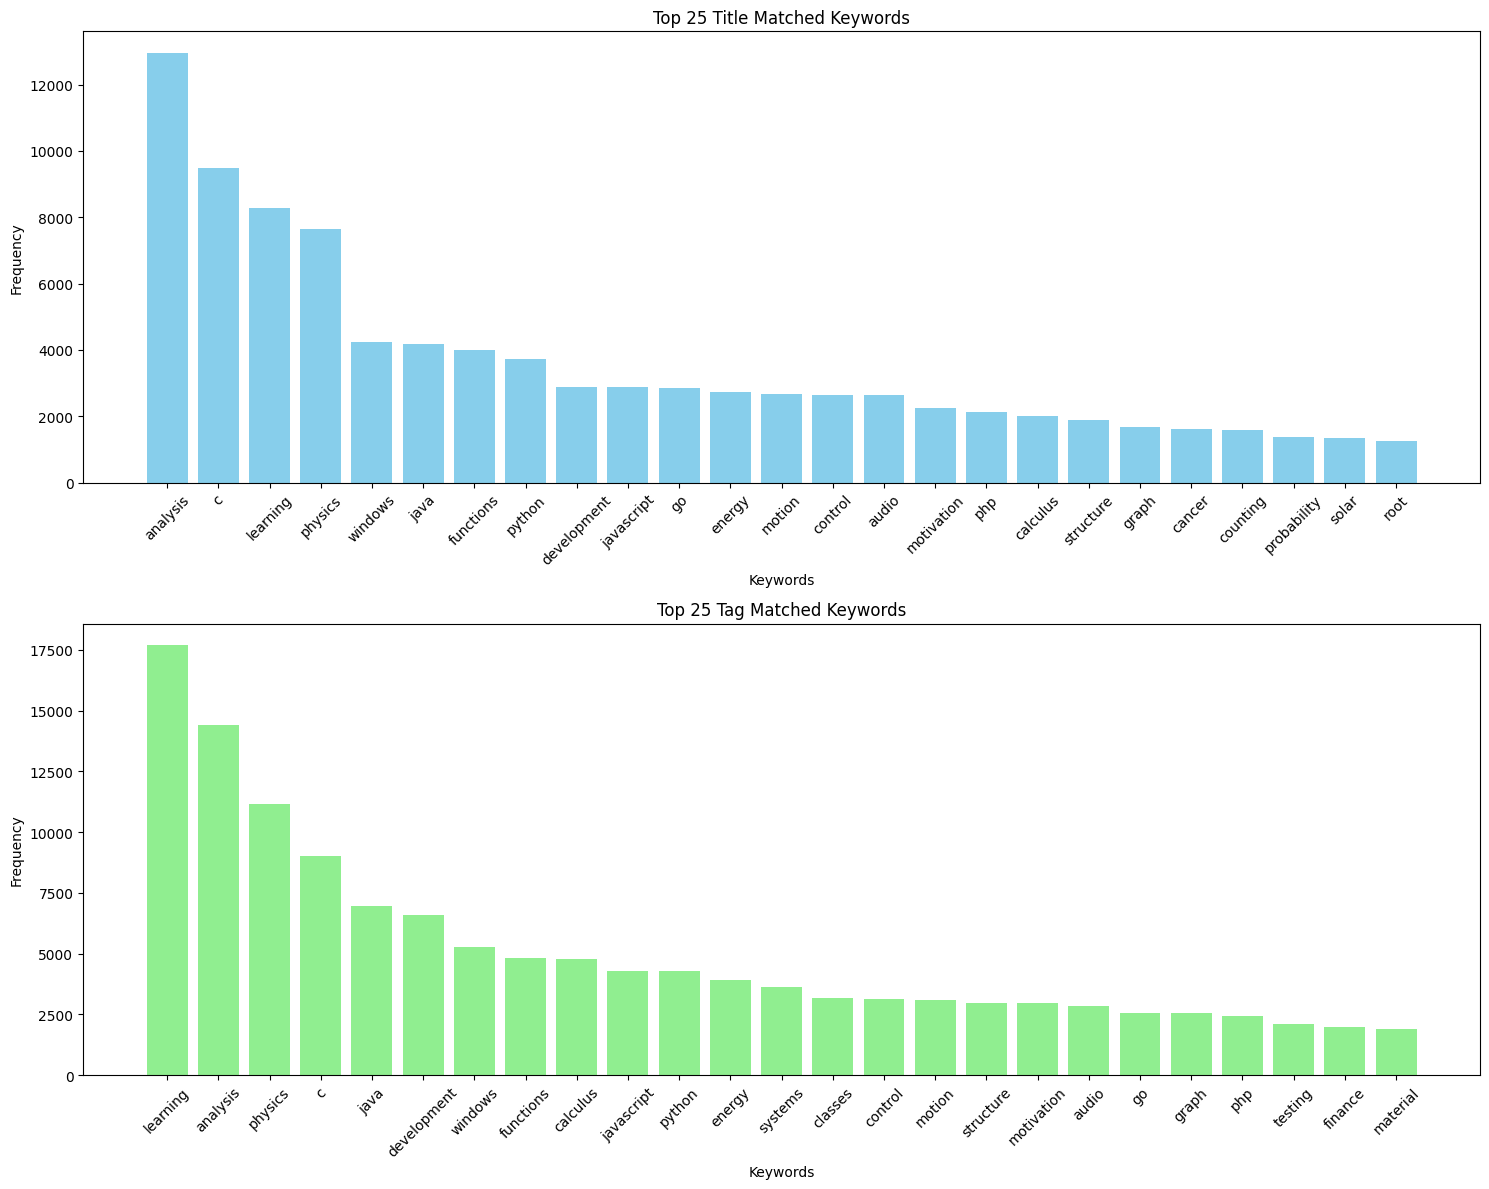

In [60]:
from collections import Counter

title_keywords = df_filtered['title_matched_keywords'].drop_nulls().to_list()
tag_keywords = df_filtered['tag_matched_keywords'].drop_nulls().to_list()

title_keywords_flat = [item.strip() for sublist in title_keywords for item in sublist.split(',') if item.strip()]
tag_keywords_flat = [item.strip() for sublist in tag_keywords for item in sublist.split(',') if item.strip()]

# Get the top 25 most common keywords
title_top_25 = Counter(title_keywords_flat).most_common(25)
tag_top_25 = Counter(tag_keywords_flat).most_common(25)

# Create subplots (one above the other)
fig, axes = plt.subplots(2, 1, figsize=(15, 12))  # 2 rows, 1 column

def plot_top_keywords(ax, top_keywords, title, color):
    keywords, counts = zip(*top_keywords)
    ax.bar(keywords, counts, color=color)
    ax.set_xlabel('Keywords')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=45)

# Plot top 25 for title_matched_keywords
plot_top_keywords(axes[0], title_top_25, 'Top 25 Title Matched Keywords', color='skyblue')

# Plot top 25 for tag_matched_keywords
plot_top_keywords(axes[1], tag_top_25, 'Top 25 Tag Matched Keywords', color='lightgreen')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

Upon analyzing the top 25 matched keywords for titles and tags, we observe that several general keywords appear with significantly high frequencies. These keywords, such as "analysis," "learning," "development," and "motivation," are broad terms that may introduce noise into our data. Including videos that only contain these general keywords might dilute the relevance of our analysis.

To maintain the quality and specificity of our dataset, we will filter out videos that contain only general keywords. For example:

Exclude:

*   Videos tagged with only "analysis" and "learning."
*   Titles containing only "motivation" and "development."

Include:


*   Videos that contain general keywords alongside more specific terms:
"analysis, python" (specific because of "python")

By applying this filtering strategy, we ensure that our analysis focuses on domain-specific content and reduces noise from overly broad keywords.

In [61]:
general_keywords = ['analysis', 'c', 'learning', 'windows', 'functions', 'development',
                    'go', 'energy', 'motion', 'control', 'audio', 'motivation', 'structure',
                    'graph', 'cancer', 'counting', 'solar', 'root',
                    'systems', 'classes', 'testing', 'finance', 'material']

# general_keywords = ['classes', 'learning', 'go', 'motivation', 'finance', 'kids learning',
#                     'c', 'insurance', 'analysis', 'innovation', 'relations', 'pressure',
#                     'audio', 'language', 'development','channels','translation','attention',
#                     'organization']

def is_only_general_keywords(keywords, general_keywords):
    if not isinstance(keywords, str):
        return False
    keyword_list = [k.strip() for k in keywords.split(',') if k.strip()]
    return all(k in general_keywords for k in keyword_list)

df_filtered = df_filtered.with_columns([
    pl.col("tag_matched_keywords").fill_null("")
])

df_filtered = df_filtered.filter(
    ~pl.col("tag_matched_keywords").map_elements(
        lambda x: is_only_general_keywords(x, general_keywords),
        return_dtype=pl.Boolean)
)
print(f"After filtering by 'tag_matched_keywords': {df_filtered.shape}")

After filtering by 'tag_matched_keywords': (84931, 19)


In [62]:
df_filtered = df_filtered.with_columns([
    pl.col("title_matched_keywords").fill_null("")
])

# Apply the function and remove rows where the only matches are in general_keywords
df_filtered = df_filtered.filter(
    ~pl.col("title_matched_keywords").map_elements(
        lambda x: is_only_general_keywords(x, general_keywords),
        return_dtype=pl.Boolean)
)
print(f"After filtering by 'title_matched_keywords': {df_filtered.shape}")

After filtering by 'title_matched_keywords': (74717, 19)


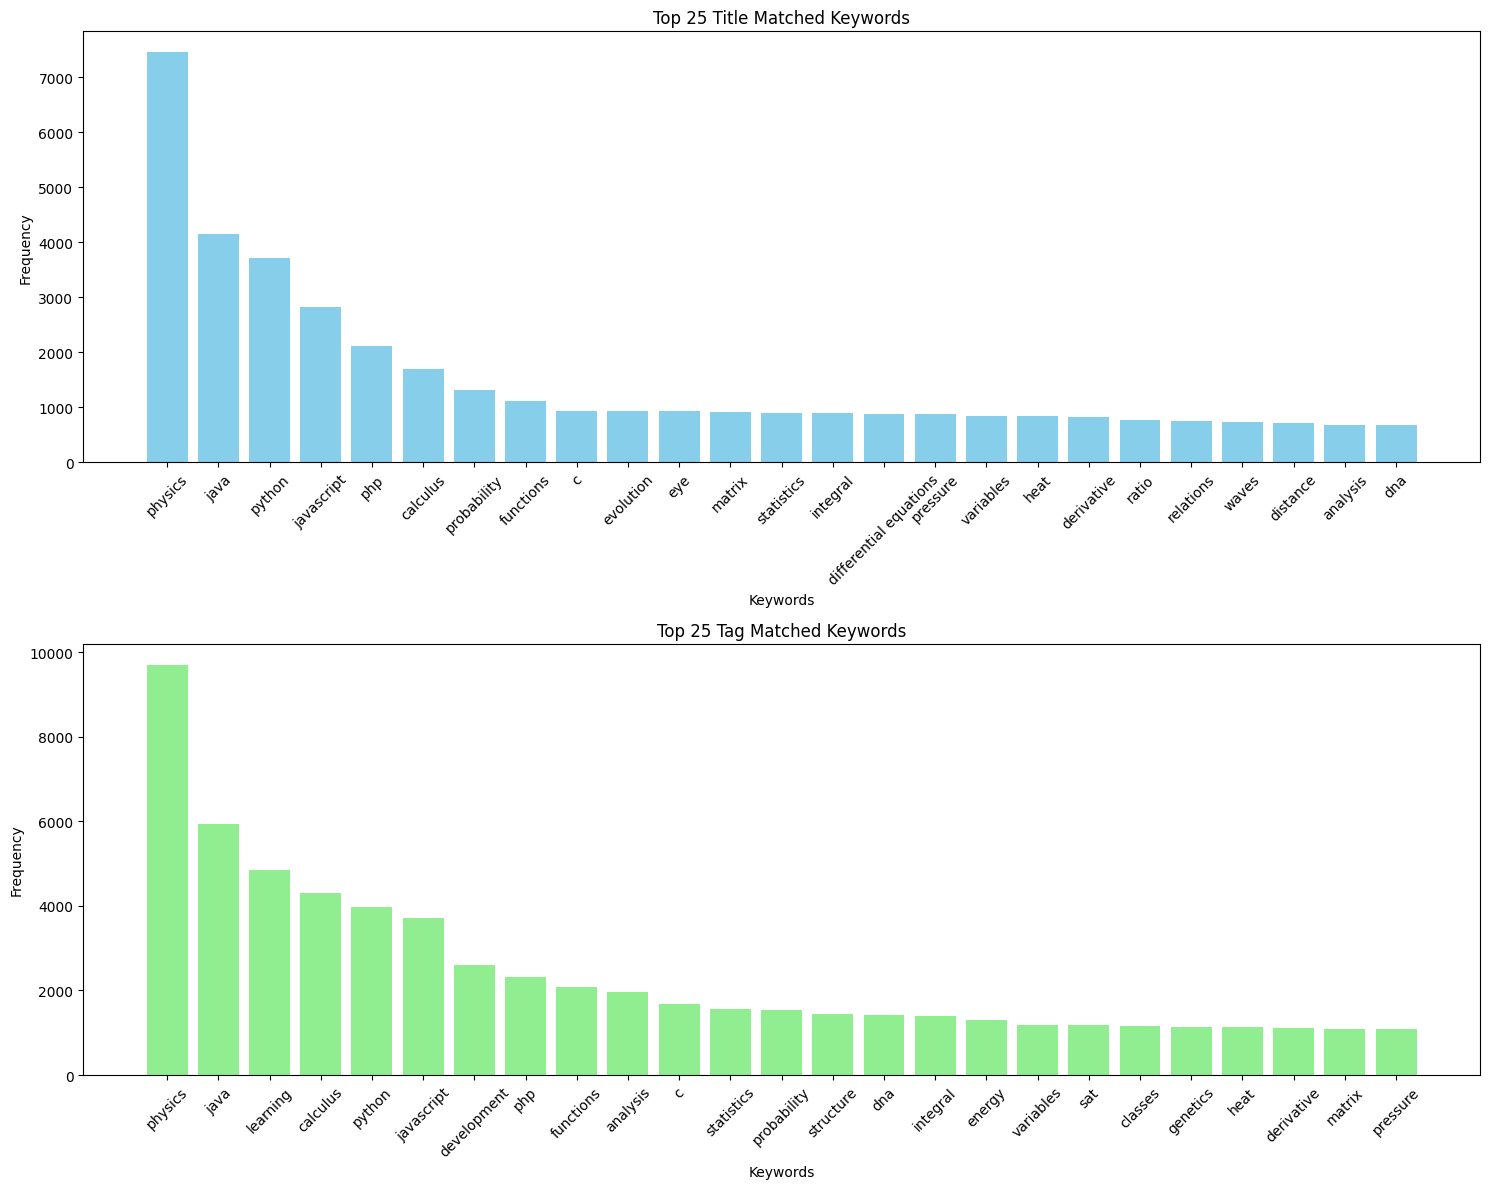

In [63]:
title_keywords = df_filtered['title_matched_keywords'].drop_nulls().to_list()
tag_keywords = df_filtered['tag_matched_keywords'].drop_nulls().to_list()

title_keywords_flat = [item.strip() for sublist in title_keywords for item in sublist.split(',') if item.strip()]
tag_keywords_flat = [item.strip() for sublist in tag_keywords for item in sublist.split(',') if item.strip()]

# Get the top 25 most common keywords
title_top_25 = Counter(title_keywords_flat).most_common(25)
tag_top_25 = Counter(tag_keywords_flat).most_common(25)

# Create subplots (one above the other)
fig, axes = plt.subplots(2, 1, figsize=(15, 12))  # 2 rows, 1 column

def plot_top_keywords(ax, top_keywords, title, color):
    keywords, counts = zip(*top_keywords)
    ax.bar(keywords, counts, color=color)
    ax.set_xlabel('Keywords')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=45)

# Plot top 25 for title_matched_keywords
plot_top_keywords(axes[0], title_top_25, 'Top 25 Title Matched Keywords', color='skyblue')

# Plot top 25 for tag_matched_keywords
plot_top_keywords(axes[1], tag_top_25, 'Top 25 Tag Matched Keywords', color='lightgreen')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

After filtering out videos that only contain general keywords, the remaining data exhibits a higher degree of domain specificity, as illustrated by the updated keyword frequency graphs.

In [64]:
stem_videos = df_filtered.to_pandas()

india = stem_videos[stem_videos['country'] == 'IN']
print(len(india))
counts = india['name_cc'].value_counts()
print(counts.shape)
counts

27049
(472,)


,count
name_cc,
Doubtnut,3058
Ekeeda,2822
Durga Software Solut...,2420
Pradeep Kshetrapal,1149
Geeky Shows,1119
...,...
Tech Garden,1
Skill Bill : Tally G...,1
BV Pattabhiram,1


The data reveals a notable concentration of Indian content creators producing educational or STEM-related content, with 27049 videos of 74717 STEM-classified videos. Specifically:


*   Channels like DoubtNut (3058 videos), Ekeeda (2822 videos), and Durga Software Solutions (2420 videos) are among the most prolific.
*   472 unique content creators, indicating a wide range of contributors in the field. There are many smaller channels with just one video each, highlighting a long tail of niche creators.

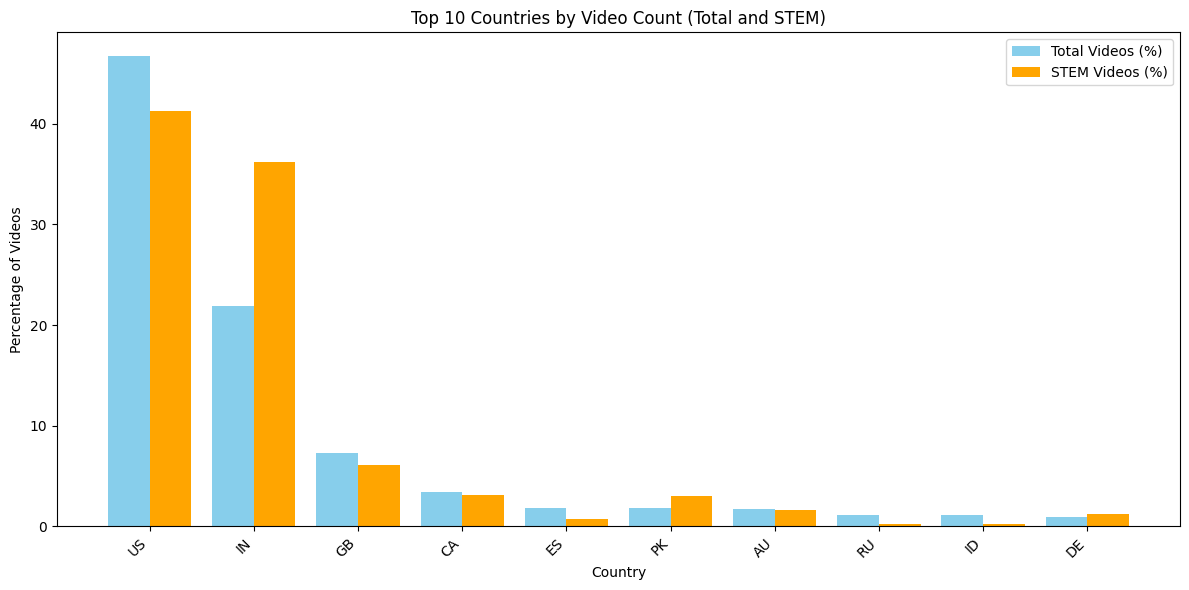

In [65]:
# Group by country and count videos
df_video = df_video_with_stem_tags.to_pandas()

country_counts = df_video.groupby("country").size().reset_index(name='count').sort_values('count', ascending=False)

# Get the top 10 countries
top_10_countries = country_counts.head(10).copy()

# Calculate relative percentages
top_10_countries["total_percentage"] = (top_10_countries["count"] / len(df_video)) * 100

# Similarly, use pandas methods for stem_country_counts
stem_country_counts = stem_videos.groupby("country").size().reset_index(name='count').sort_values('count', ascending=False)

# Merge dataframes (no change needed here)
top_10_countries = pd.merge(top_10_countries, stem_country_counts, on="country", how="left", suffixes=("_total","_stem"))
top_10_countries["stem_percentage"] = (top_10_countries["count_stem"] / len(stem_videos)) * 100
top_10_countries.fillna(0, inplace=True)

# Plotting
plt.figure(figsize=(12, 6))

bar_width = 0.4

# Total Video Percentage
plt.bar(np.arange(len(top_10_countries)), top_10_countries["total_percentage"], width=bar_width, label="Total Videos (%)", color='skyblue')

# STEM Video Percentage
plt.bar(np.arange(len(top_10_countries)) + bar_width, top_10_countries["stem_percentage"], width=bar_width, label="STEM Videos (%)", color='orange')


plt.xlabel("Country")
plt.ylabel("Percentage of Videos")
plt.title("Top 10 Countries by Video Count (Total and STEM)")
plt.xticks(np.arange(len(top_10_countries)) + bar_width / 2, top_10_countries["country"], rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

We see that the US leads with the highest percentage of total videos (~ 45%) and a significant proportion of STEM videos (~ 41%). India (IN) shows a substantial contribution to STEM videos (~ 36%) despite having a lower percentage of total videos (~ 22%), indicating a high focus on STEM content.

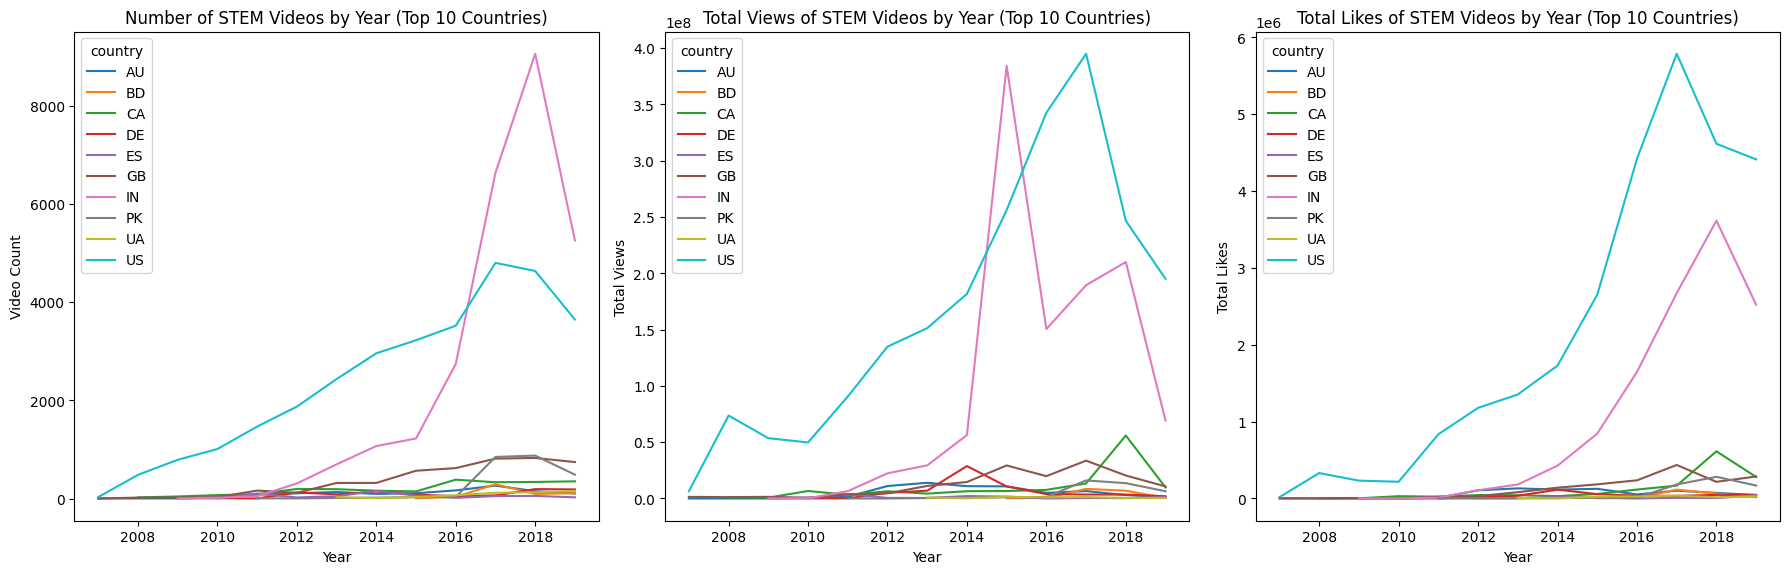

In [66]:
# Convert the 'upload_date' column to datetime objects
stem_videos['upload_date'] = pd.to_datetime(stem_videos['upload_date'], format="%Y-%m-%d %H:%M:%S")

# Extract the year from the 'upload_date'
stem_videos['upload_year'] = stem_videos['upload_date'].dt.year

# Group data by country and year
grouped_data = stem_videos.groupby(["country", "upload_year"]).agg(
    video_count=("upload_year", "size"),
    total_views=("view_count", "sum"),
    total_likes=("like_count", "sum")
).reset_index()

# Get the top 10 countries with the most STEM videos
stem_country_counts = grouped_data.groupby("country")["video_count"].sum().reset_index()
stem_country_counts = stem_country_counts.rename(columns={"video_count": "count"})
top_10_countries = stem_country_counts.sort_values("count", ascending=False).head(10)
top_10_countries_list = top_10_countries["country"].tolist()

# Filter data for the top 10 countries
top_10_df = grouped_data[grouped_data["country"].isin(top_10_countries_list)]

# Plotting
plt.figure(figsize=(18, 6))

# Setting the hue order
sorted_countries = sorted(top_10_df['country'].unique())

# Video count
plt.subplot(1, 3, 1)
sns.lineplot(x="upload_year", y="video_count", hue="country", hue_order=sorted_countries, data=top_10_df)
plt.title("Number of STEM Videos by Year (Top 10 Countries)")
plt.xlabel("Year")
plt.ylabel("Video Count")

# View count
plt.subplot(1, 3, 2)
sns.lineplot(x="upload_year", y="total_views", hue="country", hue_order=sorted_countries, data=top_10_df)
plt.title("Total Views of STEM Videos by Year (Top 10 Countries)")
plt.xlabel("Year")
plt.ylabel("Total Views")

# Like count
plt.subplot(1, 3, 3)
sns.lineplot(x="upload_year", y="total_likes", hue="country", hue_order=sorted_countries, data=top_10_df)
plt.title("Total Likes of STEM Videos by Year (Top 10 Countries)")
plt.xlabel("Year")
plt.ylabel("Total Likes")

plt.tight_layout()
plt.show()

The United States and India are the leading contributors to STEM video production, views, and engagement. The US emerged early as the dominant player in STEM content, with steady growth in video production, views, and likes. In contrast, India experienced a rapid and aggressive rise starting around 2014, significantly increasing production, viewership, and engagement. Notably, Indian creators surpassed US viewership between 2014 and 2016 before experiencing a decline. Despite India’s surge, the US maintains higher overall engagement, consistently outperforming other countries in total likes and sustaining strong viewership trends.

This highlights the US’s long-standing dominance and India’s rapid growth in the STEM content landscape. We will continue to analyse this data.

In [67]:
df_filtered.write_csv("/content/drive/MyDrive/data-final/stem_videos_final.csv")